# Data Center Model (Server Model)

Model Simulation

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from scipy import signal
from tqdm import tqdm

### The Server Model

In [2]:
def server_model_simulation(t_sim, initial_month = 0, initial_number_users = 0, initial_rate_data = 0):
    
#     np.random.seed(140)
    
    ## Parameters  
    h_c = np.ones([3,2]) * 0.002  # [element, zone]
    h_c += (np.random.rand(3,2)-0.5) * 0.0001

    h_f = np.ones([3,2]) * 0.2 # [element, zone]
    h_f += (np.random.rand(3,2)-0.5) * 0.01
    c_p = 1
    
    lambda_1 = np.ones(3) / 3  # [to element zone 1]
    lambda_2 = np.array([[5,2,1],
                         [3,5,3],
                         [1,2,5]]) / 9  # [from el. zone 1, to el. zone 2]
    lambda_3 = np.ones(3)  # [to element zone 3]
    
    
    R = np.ones([3,2,3,2]) * 0.0001  # [3,2, el pos, zone pos]
    for j in range(3):
        for i in range(2):
            R[j,i,j,i] = 0
            i_min = max(i-1,0)
            i_max = min(i+1,1)
            j_min = max(j-1,0)
            j_max = min(j+1,2)
            R[j,i,j_min:j_max+1,i_min:i_max+1] *= 2

    rho = np.ones([3,2]) * 0.0001
    rho[:,1] = rho[:,1] / 5
    
    b = np.ones([3,2]) * 8 
    b[1] = 1
    b /= np.sum(b)
    
    step_size = 1
    
    
    ## Exogenous Inputs
    # n° of users
    min_number_users = 0
    max_number_users = 100
    max_update_users = 2
    
    # data rate/user
    min_rate_data = 0
    max_rate_data = 300
    max_update_data = 6
    
    # power
    delta_number_users = np.random.randint(-max_update_users, max_update_users+1, t_sim)
    delta_rate_data = np.random.randint(-max_rate_data, max_rate_data+1, t_sim)
    power = np.zeros(t_sim+1)
    
    
    # inlet temperature
    T_in = 2 * np.sin(2 * np.pi / (60*24) * np.array(range(t_sim))) + 20
    
    # input (volume flow)
    u = np.ones(t_sim) * 5
    u[1000:2000] = 50
    u[2000:3000] = 100
    
    ## Simulation
    # initializiation
    T_c = np.zeros([t_sim+1,3,2]) # [t, element, zone]
    T_c[0,:,:] = T_in[0]
    T_f = np.zeros([t_sim,3,2]) # [t, element, zone]
    T_out = np.zeros([t_sim,1]) # [t]
    f = np.zeros([t_sim,3,2])   # [t, element]
          
    number_users = initial_number_users
    rate_data = initial_rate_data 
    
    
    for t in tqdm(range(t_sim)):
        
        # T_f zone 1
        T_f[t,:,0] = T_in[t] 
        f[t,:,0] = lambda_1 * u[t]
    
        # T_f zone 2
        for j in range(3): # el in zone 2
            for k in range(3): # el in zone 1
                T_f[t,j,1] += lambda_2[k,j] * f[t,k,0] * (T_in[t] + h_f[k,0] * (T_c[t,k,0]-T_in[t]) / c_p)
                f[t,j,1] += lambda_2[k,j] * f[t,k,0]
            T_f[t,j,1] /= f[t,j,1]
            
        # T_out zone 3
        for k in range(3):
            T_out[t] += lambda_3[k] * f[t,k,1] * (T_f[t,k,1] + h_f[k,1] * (T_c[t,k,1]-T_f[t,k,1]) / c_p)
        T_out[t] /= u[t] 

        
        # Power consumption
        number_users = np.clip(number_users + delta_number_users[t], min_number_users, max_number_users)
        rate_data = np.clip(rate_data + delta_rate_data[t], min_rate_data, max_rate_data)
        power[t+1] = number_users * rate_data / (max_number_users * max_rate_data)
        
        # Next state 
        for j in range(3):
            for i in range(2):
                T_c[t+1,j,i] = T_c[t,j,i] + step_size * (- h_c[j,i] * f[t,j,i] * (T_c[t,j,i] - T_f[t,j,i]) + np.sum(T_c[t]*R[j,i,:,:]) + rho[j,i] * T_in[t] +  b[j,i] * power[t])
#                 print(t+1)
#                 print(- h_c[j,i] * f[t,j,i] * (T_c[t,j,i] - T_f[t,j,i]))
#                 print(np.sum(T_c[t]*R[j,i,:,:]))
#                 print(rho[j,i] * T_in[t])
#                 print(b[j,i] * power[t])
#                 print("-------")
                
    return T_c, T_f, T_out, power, T_in, f
    

### The Simulation



100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 4770.30it/s]


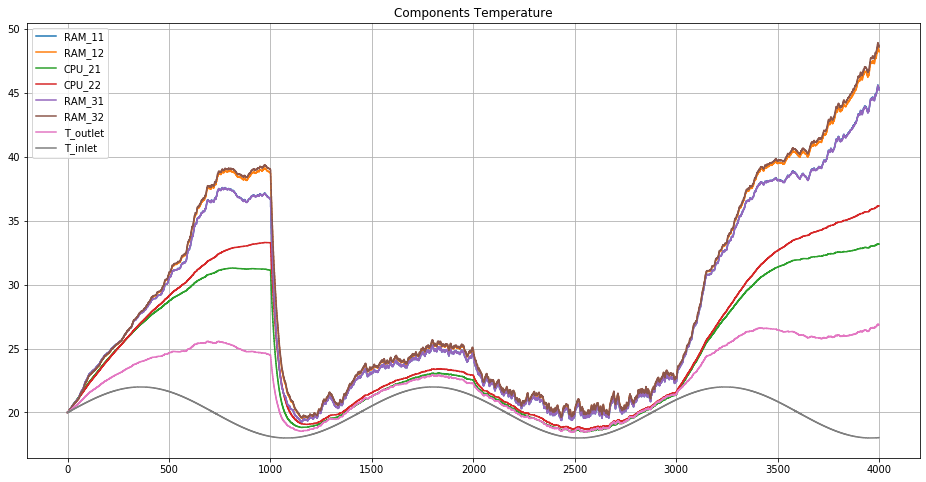

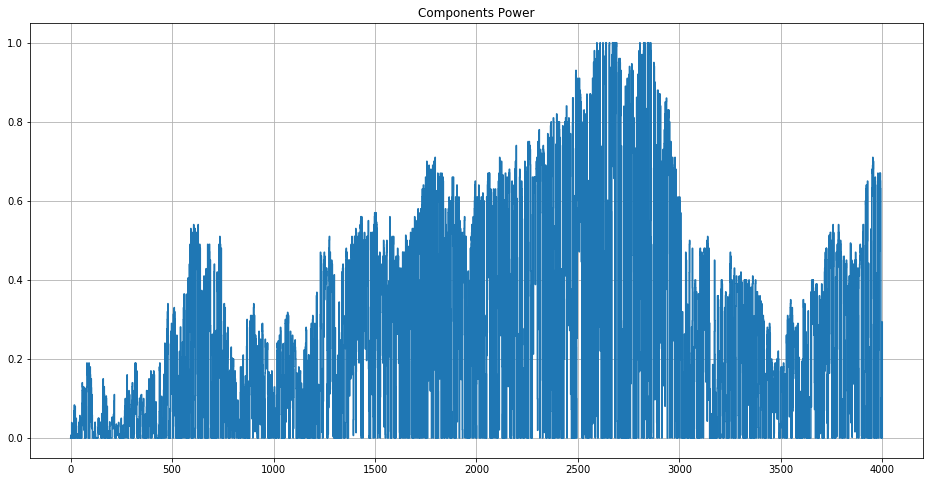

In [3]:
t_sim = 4000# [min]

#T_model = datacenter_model(t_sim, initial_month = 0, initial_number_users = 10, initial_rate_data = 60)
T_c, T_f, T_out, power, T_in, f = server_model_simulation(t_sim, initial_month = 0, initial_number_users = 0, initial_rate_data = 0)

time = range(t_sim+1)
plt.figure(figsize=(16,8))
plt.step(time*np.ones(t_sim+1), T_c.reshape(-1,6), where='post')
plt.step(time[:-1],T_out, where='post')
plt.step(time[:-1],T_in, where='post')
plt.grid(True)
plt.title('Components Temperature')
plt.legend(['RAM_11', 'RAM_12', 'CPU_21', 'CPU_22', 'RAM_31', 'RAM_32', 'T_outlet', 'T_inlet'])
plt.show()

# plt.figure(figsize=(16,8))
# plt.plot(T_f.reshape(-1,6))
# # plt.plot(T_in)
# plt.grid(True)
# plt.title('Flow Temperature')
# plt.legend(['RAM_11', 'RAM_12', 'CPU_21', 'CPU_22', 'RAM_31', 'RAM_32'])
# plt.show()


plt.figure(figsize=(16,8))
plt.step(time, power, where='post')
plt.grid(True)
plt.title('Components Power')
plt.show()



In [ ]:
class server_model():
    def __init__(self, )